# <center> **Kaggle Data Set**

This dataset contains user transitions between pages. The goal of this challenge is to recognize one user amongst all others. The dataset consists of user sessions, each session is a sequence of transitions between pages. A sequence can be one to ten pages long.

# Table of Contents

1. **[Functions](#1)**
2. **[Dropping duplicates](#2)**
3. **[Missing data](#3)**
4. **[EDA](#4)**
5. **[Split](#5)**
6. **[Feature engineering](#6)**
7. **[More EDA](#7)**
8. **[Correlation](#8)**
9. **[More preprocessing](#9)**
10. **[Logistic Regression](#10)**

In [362]:
! pip install fastparquet

In [363]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

import pylab as pl
from scipy.special import boxcox1p
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import norm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler,PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, \
                                    RepeatedStratifiedKFold, train_test_split, \
                                    validation_curve,TimeSeriesSplit
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

In [364]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [365]:
train = pd.read_csv('/content/drive/My Drive/DA/HW7/train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)]) 
test = pd.read_csv('/content/drive/My Drive/DA/HW7/test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

In [366]:
id_map =  pd.read_parquet('/content/drive/My Drive/DA/HW7/id_map.parquet', engine='fastparquet')
id_map

,id,webpage
0,326127,www.abmecatronique.com
1,182113,groups.live.com
2,551820,majeureliguefootball.wordpress.com
3,401995,cdt46.media.tourinsoft.eu
4,105504,www.hdwallpapers.eu
...,...,...
48366,386746,i1-js-14-3-01-11074-747051290-i.init.cedexis-r...
48367,530474,i1-js-14-3-01-12434-548464295-i.init.cedexis-r...
48368,142359,embed.api.tv
48369,520516,n-tennis.fr


# **Functions**

**Methods to find outliers**

In [466]:
def count_iqr(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  out = (data <(Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
  for col in data.columns: 
    outer = (data[col] == True).sum()
    if outer != 0:
        print(f'{col} -> outliers: -> {outer}')

In [467]:
def Zscore_outlier(df, feature_name):
    out= 0
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out += 1
    print(f"{feature_name}:\nOutliers amount: {out}\n")

**Plotting histograms & transformations**

In [468]:
def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [469]:
def draw_lognorm(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist)
    plt.title("Distribution BEFORE Log transformation")
    plt.xlabel("values")
    mean=data.mean()
    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()
    sns.despine()
    plt.show()

    f,ax_hist = plt.subplots(1)
    sns.distplot(np.log1p(data), hist=True,  kde=True, rug=True, fit=norm,  ax=ax_hist)
    plt.title("Distribution AFTER Log transformation")
    plt.xlabel("values")
    mean=np.log1p(data).mean()
    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()
    sns.despine()

    plt.show()

In [470]:
def draw_boxcox(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist)
    plt.title("Distribution BEFORE Log transformation")
    plt.xlabel("values")
    mean=data.mean()
    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()
    sns.despine()
    plt.show()

    f,ax_hist = plt.subplots(1)
    sns.distplot(boxcox1p(data, 0.25), hist=True,  kde=True, rug=True, fit=norm,  ax=ax_hist)
    plt.title("Distribution AFTER Log transformation")
    plt.xlabel("values")
    mean=boxcox1p(data, 0.25).mean()
    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()
    sns.despine()

    plt.show()

In [471]:
def count_skewness_kurtosis(data):
    print("Skewness: %f" % data.skew())
    print("Kurtosis: %f" % data.kurt())

**Normality Tests**  

*Shapiro-Wilk Test*  

Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.  

In [472]:
def shapiro_normality_testing(data):
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

**Missing data**

In [473]:
def find_manyNaN_rows(data, amount):
    inds = []
    counter = 0
    for i in range(len(data.index)):
      if data.iloc[i].isnull().sum() >= amount:
        counter += 1
        inds.append(i)
    print(f'Rows with NaN >= {amount}: ', counter)

In [474]:
# summarize the number of rows with missing values for each column
def get_nans_percentage(data):
  for i in data.columns:
      # count number of rows with missing values
      n_miss = data[i].isnull().sum()
      perc = n_miss / data.shape[0] * 100
    
      if n_miss != 0:
          print(f'Column: {i}\nAmount {n_miss}\n%{perc}\n')

**Quality evaluation**

In [475]:
!ls

%cd /content/drive/My Drive/DA/HW5/

from plot_cm import plot_confusion_matrix
from plot_roc import plot_roc

catboost_info			    HW5_Ozhiganova.ipynb     plot_cm.py
dataset_57_hypothyroid.csv	    HW6			     plot_roc.py
GoogleNews-vectors-negative300.bin  notebook_submission.csv  __pycache__
/content/drive/My Drive/DA/HW5


In [476]:
def calc_metrics(test_label, preds):
    classes_names = ['0', '1']
    num_classes = 2

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

**ROC AUC**

In [477]:
classes_names = ['0', '1']
num_classes = 2

In [478]:
def count_roc_auc(model, testData, test_label, num_classes, classes_names):
    preds_prob = model.predict_proba(testData)[:,1]


    print('ROC AUC:',
         '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
         '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    plot_roc(test_label, preds_prob, target_names=classes_names)

**Save output**

In [479]:
def save_submission(pred, f_name):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv(f'/content/drive/My Drive/DA/HW7/{f_name}')

# **Dropping duplicates**

In [381]:
train.shape

(159969, 21)

In [382]:
train.drop_duplicates(inplace=True)
train.shape

(159953, 21)

* 16 duplicates were found & deleted.

# **Missing data**

In [383]:
train.shape

(159953, 21)

In [384]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159953 entries, 0 to 159968
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   webpage1   159953 non-null  int64         
 1   time1      159953 non-null  datetime64[ns]
 2   webpage2   157982 non-null  float64       
 3   time2      157982 non-null  datetime64[ns]
 4   webpage3   156058 non-null  float64       
 5   time3      156058 non-null  datetime64[ns]
 6   webpage4   154394 non-null  float64       
 7   time4      154394 non-null  datetime64[ns]
 8   webpage5   152833 non-null  float64       
 9   time5      152833 non-null  datetime64[ns]
 10  webpage6   151316 non-null  float64       
 11  time6      151316 non-null  datetime64[ns]
 12  webpage7   149904 non-null  float64       
 13  time7      149904 non-null  datetime64[ns]
 14  webpage8   148566 non-null  float64       
 15  time8      148566 non-null  datetime64[ns]
 16  webpage9   147152 no

In [385]:
test.shape

(93338, 20)

In [386]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93338 entries, 0 to 93337
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   webpage1   93338 non-null  int64         
 1   time1      93338 non-null  datetime64[ns]
 2   webpage2   91859 non-null  float64       
 3   time2      91859 non-null  datetime64[ns]
 4   webpage3   90606 non-null  float64       
 5   time3      90606 non-null  datetime64[ns]
 6   webpage4   89674 non-null  float64       
 7   time4      89674 non-null  datetime64[ns]
 8   webpage5   88744 non-null  float64       
 9   time5      88744 non-null  datetime64[ns]
 10  webpage6   87929 non-null  float64       
 11  time6      87929 non-null  datetime64[ns]
 12  webpage7   87143 non-null  float64       
 13  time7      87143 non-null  datetime64[ns]
 14  webpage8   86409 non-null  float64       
 15  time8      86409 non-null  datetime64[ns]
 16  webpage9   85685 non-null  float64      

* At 1st glance, it can be seen, that there are many outliers in train and test data.

Total amount of NaNs:

In [387]:
print(f'Total amount of NaNs in Train:  {train.isnull().sum().sum()}')
print(f'Total amount of NaNs in Test:  {test.isnull().sum().sum()}')

Total amount of NaNs in Train:  151048
Total amount of NaNs in Test:  94068


Each column with amount of NaNs:

In [388]:
print('TRAIN: \n')
train.isna().sum()

TRAIN: 



webpage1         0
time1            0
webpage2      1971
time2         1971
webpage3      3895
time3         3895
webpage4      5559
time4         5559
webpage5      7120
time5         7120
webpage6      8637
time6         8637
webpage7     10049
time7        10049
webpage8     11387
time8        11387
webpage9     12801
time9        12801
webpage10    14105
time10       14105
target           0
dtype: int64

* 9 features (from 15) have missed values.
* These features contain many missing values, especially **webpage10** column --> 14105 from 156336 (all). It has to be deleted later.
* **webpage9** has also many missing values (12801 from 156336). 

In [389]:
print('TEST: \n')
test.isna().sum()

TEST: 



webpage1        0
time1           0
webpage2     1479
time2        1479
webpage3     2732
time3        2732
webpage4     3664
time4        3664
webpage5     4594
time5        4594
webpage6     5409
time6        5409
webpage7     6195
time7        6195
webpage8     6929
time8        6929
webpage9     7653
time9        7653
webpage10    8379
time10       8379
dtype: int64

* There is the same tendency in missing values:
* 9 features (from 15) have missed values.
* These features contain many missing values, especially **webpage10** column --> 8379 from 88761 (all). It has to be deleted later.
* **webpage9** has also many missing values (7653 from 88761).

  **The most widely used methods to deal with missing data are:**  
1) create a new category for NaN values  
2) impute median/mode/mean(depends on data types) 
_______________________________________________
  
Of course, each method has its pros and cons, such:  
1)  
+: Simple and easy to implement for categorical variables/columns and preserves the variance.  
-: May create random data if the missing category is more.
Doesn’t give good results when missing data is a high percentage of the data.  

2)  
+: Simple and easy to implement.
-: Features having a max number of null values may bias prediction if replace with the most occurred category.
It distorts the relation of the most frequent label.


**Analyses of how to handle the missing data.**  
We'll consider that when more than/equal 70% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables that we should delete.
**!** Firstly, I'll drop rows, where exist NaNs more than >= 17 (more than half).

In [390]:
find_manyNaN_rows(train, 17)

Rows with NaN >= 17:  1971


In [391]:
find_manyNaN_rows(test, 17)

Rows with NaN >= 17:  1479


* There are no rows in which there are extremely many gaps in the data.

Summarize the number of rows with missing values for each column:

In [392]:
get_nans_percentage(train)

Column: webpage2
Amount 1971
%1.232236969609823

Column: time2
Amount 1971
%1.232236969609823

Column: webpage3
Amount 3895
%2.43509030777791

Column: time3
Amount 3895
%2.43509030777791

Column: webpage4
Amount 5559
%3.4753958975449035

Column: time4
Amount 5559
%3.4753958975449035

Column: webpage5
Amount 7120
%4.451307571599157

Column: time5
Amount 7120
%4.451307571599157

Column: webpage6
Amount 8637
%5.3997111651547645

Column: time6
Amount 8637
%5.3997111651547645

Column: webpage7
Amount 10049
%6.282470475702237

Column: time7
Amount 10049
%6.282470475702237

Column: webpage8
Amount 11387
%7.1189661963201685

Column: time8
Amount 11387
%7.1189661963201685

Column: webpage9
Amount 12801
%8.002975874163036

Column: time9
Amount 12801
%8.002975874163036

Column: webpage10
Amount 14105
%8.818215350759285

Column: time10
Amount 14105
%8.818215350759285



In [393]:
get_nans_percentage(test)

Column: webpage2
Amount 1479
%1.584563628961409

Column: time2
Amount 1479
%1.584563628961409

Column: webpage3
Amount 2732
%2.926996507317491

Column: time3
Amount 2732
%2.926996507317491

Column: webpage4
Amount 3664
%3.925518009813795

Column: time4
Amount 3664
%3.925518009813795

Column: webpage5
Amount 4594
%4.921896762304742

Column: time5
Amount 4594
%4.921896762304742

Column: webpage6
Amount 5409
%5.795067389487669

Column: time6
Amount 5409
%5.795067389487669

Column: webpage7
Amount 6195
%6.637168141592921

Column: time7
Amount 6195
%6.637168141592921

Column: webpage8
Amount 6929
%7.423557393558894

Column: time8
Amount 6929
%7.423557393558894

Column: webpage9
Amount 7653
%8.199232895498081

Column: time9
Amount 7653
%8.199232895498081

Column: webpage10
Amount 8379
%8.977051147442626

Column: time10
Amount 8379
%8.977051147442626



Features *webpage 2 - 10*  have  some missing data  (from 1 to 9 %),  I think, that it is not a huge percentage and I can emplace missing data by using MICE.  


**Multivariate feature imputation - Multivariate imputation by chained equations (MICE)**  

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value.

In [394]:
mice_imputer = IterativeImputer()
# cols_nan = ['webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6', 'webpage7', 'webpage8', 'webpage9', 'webpage10']

In [395]:
for col in train.columns:
  train[col] = mice_imputer.fit_transform(train[[col]])

In [396]:
train.isnull().sum().sum()

0

In [397]:
for col in test.columns:
  test[col] = mice_imputer.transform(test[[col]])

test.isnull().sum().sum()

0

* MICE is more powerful than the usage of median, for example, so I decided to use it here to fill in missing values.

# **Outliers**

**IQR method**

In [398]:
count_iqr(train)

target -> outliers: -> 1575


In [399]:
count_iqr(test)

**Z-SCORE method**

In [400]:
NUMERICAL = train.select_dtypes(exclude=['category', 'object']).columns.tolist()

In [401]:
for col in NUMERICAL:
    Zscore_outlier(train[col], col)

webpage1:
Outliers amount: 5856

time1:
Outliers amount: 4291

webpage2:
Outliers amount: 5835

time2:
Outliers amount: 1971

webpage3:
Outliers amount: 5783

time3:
Outliers amount: 3895

webpage4:
Outliers amount: 5813

time4:
Outliers amount: 5559

webpage5:
Outliers amount: 5718

time5:
Outliers amount: 7120

webpage6:
Outliers amount: 5766

time6:
Outliers amount: 8637

webpage7:
Outliers amount: 5789

time7:
Outliers amount: 10049

webpage8:
Outliers amount: 5735

time8:
Outliers amount: 11387

webpage9:
Outliers amount: 5762

time9:
Outliers amount: 12801

webpage10:
Outliers amount: 5766

time10:
Outliers amount: 14105

target:
Outliers amount: 1575



In [402]:
for col in test.columns:
    Zscore_outlier(test[col], col)

webpage1:
Outliers amount: 3290

time1:
Outliers amount: 0

webpage2:
Outliers amount: 3260

time2:
Outliers amount: 1479

webpage3:
Outliers amount: 3323

time3:
Outliers amount: 2732

webpage4:
Outliers amount: 3287

time4:
Outliers amount: 3664

webpage5:
Outliers amount: 3324

time5:
Outliers amount: 4594

webpage6:
Outliers amount: 3291

time6:
Outliers amount: 5409

webpage7:
Outliers amount: 3313

time7:
Outliers amount: 6195

webpage8:
Outliers amount: 3302

time8:
Outliers amount: 6929

webpage9:
Outliers amount: 3285

time9:
Outliers amount: 7653

webpage10:
Outliers amount: 3245

time10:
Outliers amount: 8379



**Conclusion**
* Analyzing the emissions, in general, there are not very many of them.
* I can delete outlier values if it is due to data entry error, data processing error or outlier observations are very small in numbers. I can also use trimming at both ends to remove outliers. 
* But deleting the observation is not a good idea when we have small dataset.

* Transforming variables can also eliminate outliers. These transformed values reduces the variation caused by extreme values.

So, later I'll use some **transformation methods.**

# **EDA**

**Merge Train & Test**

In [403]:
full_df = pd.concat([train, test], sort=False)
full_df.head(2)

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486.0,1.550642e+18,44594.473921,-9.223372e+18,45026.885581,-9.223372e+18,45449.212159,-9.223372e+18,45664.83056,-9.223372e+18,45821.494601,-9.223372e+18,46411.955385,-9.223372e+18,46814.486275,-9.223372e+18,46972.593081,-9.223372e+18,47560.100474,-9.223372e+18,0.0
1,11722.0,1.550820e+18,12385.000000,1.550820e+18,50163.000000,1.550820e+18,12385.000000,1.550820e+18,12398.00000,1.550820e+18,50150.000000,1.550820e+18,50163.000000,1.550820e+18,50150.000000,1.550820e+18,19860.000000,1.550820e+18,19886.000000,1.550820e+18,0.0


Descriptive statistics for df features.

In [404]:
full_df.describe(include='all')

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
count,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,253291.000000,2.532910e+05,159953.000000
mean,42321.893648,1.547737e+18,42457.494983,1.401020e+18,42666.910243,1.265916e+18,42792.921065,1.155525e+18,42880.318672,1.049599e+18,42870.767762,9.504328e+17,43286.576186,8.569640e+17,43608.858121,7.688547e+17,43598.897120,6.779391e+17,43773.752619,5.916136e+17,0.009847
std,94220.444568,8.043679e+15,94401.604987,1.248509e+18,94363.413966,1.719322e+18,94205.159164,2.017605e+18,93864.201325,2.262165e+18,93461.130134,2.465139e+18,93754.714785,2.638803e+18,93855.148515,2.789776e+18,93435.279923,2.934663e+18,93325.473645,3.063403e+18,0.098741
min,165.000000,1.515730e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.009847,-9.223372e+18,0.000000
25%,841.000000,1.544785e+18,841.000000,1.544678e+18,828.000000,1.544592e+18,828.000000,1.543479e+18,828.000000,1.543387e+18,828.000000,1.543307e+18,828.000000,1.543229e+18,828.000000,1.543162e+18,828.000000,1.543132e+18,828.000000,1.543123e+18,0.000000
50%,8953.000000,1.550402e+18,8953.000000,1.550380e+18,8953.000000,1.550139e+18,8966.000000,1.550063e+18,9239.000000,1.550053e+18,9434.000000,1.550041e+18,9681.000000,1.550033e+18,9863.000000,1.549278e+18,9889.000000,1.549270e+18,9928.000000,1.549263e+18,0.000000
75%,25892.000000,1.553087e+18,26126.000000,1.553066e+18,29948.000000,1.553060e+18,31716.000000,1.553058e+18,33718.000000,1.553055e+18,34147.000000,1.552994e+18,36305.000000,1.552987e+18,38021.000000,1.552982e+18,39568.000000,1.552981e+18,42922.000000,1.552980e+18,0.000000
max,540965.000000,1.556653e+18,540952.000000,1.556653e+18,540939.000000,1.556653e+18,540939.000000,1.556653e+18,540939.000000,1.556653e+18,540952.000000,1.556653e+18,540952.000000,1.556653e+18,540965.000000,1.556653e+18,540965.000000,1.556653e+18,540965.000000,1.556653e+18,1.000000


**Conclusion**  

* Since we are working with distances between objects, heterogeneity in the values of features can greatly distort the results of the analysis. So, a feature that itself takes high values can be decisive when calculating distances, while features with low values may have almost no effect.

* To solve this problem, I later perform *STANDARDIZATION* of the data.


### **Target variable**

In [405]:
full_df['target'].value_counts()

0.0    158378
1.0      1575
Name: target, dtype: int64

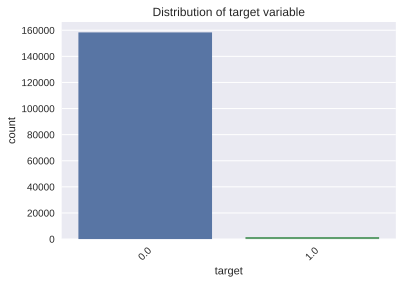

In [406]:
sns.countplot(full_df['target']);
plt.title('Distribution of target variable')
plt.xticks(rotation=45)
plt.show()

**Conclusion**

* In the training sample - 1575 sessions of one user and 158394 sessions of other users. The class imbalance is very strong, and it is not indicative to look at the proportion of correct answers (accuracy).
* In the future, MAYBE I'm going to use the *'SMOTE'* algorithm to avoid the problem of data imbalance.

* Since only two observations are presented in the "secondary_hypothyroid" class, it would be possible to try to duplicate two lines of data in the test and then, after applying "SMOTE", delete them from the train, but I am not sure that this approach is correct and that there will be no information leakage, I also can't give any guarantees, so I thought it necessary to delete this class at the moment, since there is a clear lack of data.

In [407]:
train_test_df_sites = full_df[['webpage%d' % i for i in range(1, 11)]]

In [408]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['webpage%s' % i for i in range(1, 11)]

In [409]:
from scipy.sparse import csr_matrix, hstack, vstack

In [410]:
%%time
train_test_sparse = csr_matrix(([1]*train_test_df_sites.size,np.array(train_test_df_sites).flatten(),
                               range(0,train_test_df_sites.size+1,train_test_df_sites.shape[1])))[:,1:]

X_train_sparse = train_test_sparse[:len(train)]
X_test_sparse = train_test_sparse[len(train):]
y = train.target.values

CPU times: user 311 ms, sys: 56 ms, total: 367 ms
Wall time: 370 ms


In [411]:
print('X_train_sparse dimensionality:')
print(X_train_sparse.shape)
print('X_test_sparse dimensionality:')
print(X_test_sparse.shape)

X_train_sparse dimensionality:
(159953, 540965)
X_test_sparse dimensionality:
(93338, 540965)


# **Split**

Split the training sample into 2 parts and without mixing. The initial data is ordered by time, the test sample is clearly separated from the training sample by time, we will observe the same here.

In [412]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

# **Feature engineering**

This function helps to count time, which was spend on webpage, find days of week, unique webpages.

In [413]:
def feature_engineering(sessions):

    new_features = pd.DataFrame()
    
    timestamps = sessions[['time%s' % i for i in range(1, 11)]]
    # sites = sessions[['webpage%s' % i for i in range(1, 11)]].fillna(0).astype(int).values

    sites = mice_imputer.fit_transform(sessions[['webpage%s' % i for i in range(1, 11)]])

    for td_index in range(1, 10):
        new_features['time_diff{}'.format(td_index)] = (pd.to_datetime(timestamps['time{}'.format(td_index + 1)]) - 
                                                pd.to_datetime(timestamps['time{}'.format(td_index)])
                                               ).dt.total_seconds().fillna(0)
    
    new_features['session_timespan'] = np.sum(new_features, axis=1)
    new_features['start_hour'] = pd.to_datetime(timestamps['time1']).dt.hour
    new_features['day_of_week'] = pd.to_datetime(timestamps['time1']).dt.weekday
    new_features['unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]

    return new_features

In [414]:
train_test_new = feature_engineering(train)
train_test_new.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,start_hour,day_of_week,unique_sites
session_id,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2,10
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,7,4,7
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,12,6,4
3,0.0,0.0,0.0,30.0,69.0,0.0,1.0,1.0,1.0,102.0,12,2,7
4,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,6,3,7


# **More EDA**

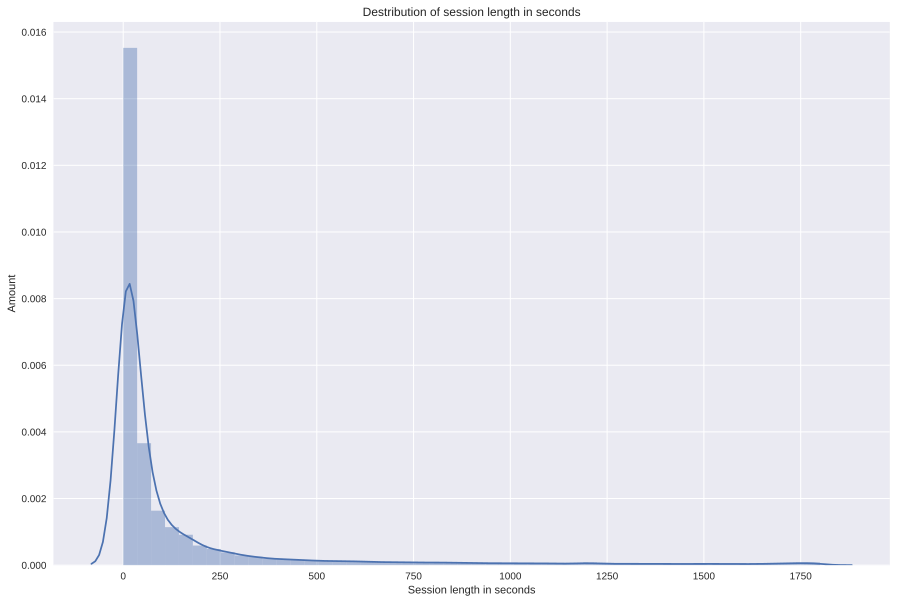

In [415]:
plt.figure(figsize=(15, 10))
sns.distplot(train_test_new['session_timespan'])

plt.xlabel('Session length in seconds')
plt.ylabel('Amount')
plt.title('Destribution of session length in seconds')
plt.grid(True)
plt.show()

We've got an intuition: different people might prefer to visit (even the same) sites at *different* times of the day. Let's first draw the distribution of all session start hours. 

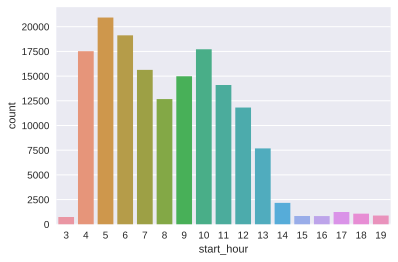

In [416]:
sns.countplot(train_test_new['start_hour'])
plt.show()

Now the same separately for our user and other people.

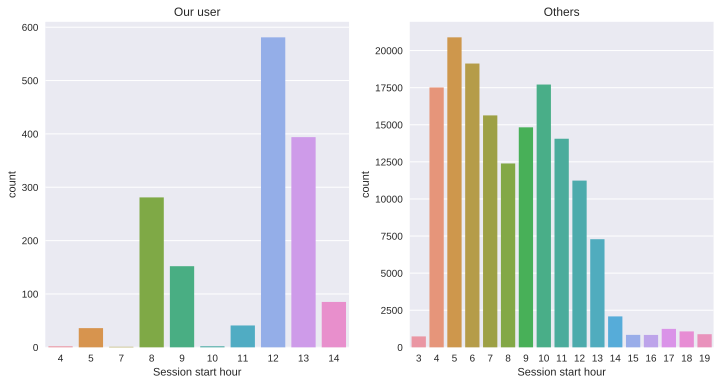

In [417]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(train_test_new['start_hour'][y == 1])
plt.title("Our user")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(train_test_new['start_hour'][y == 0])
plt.title('Others')
plt.xlabel('Session start hour');

Now we definitely see that our user mostly prefers 12-13 pm for browsing. So let's create features 'morning', 'day' and 'evening' and 'night'. Separators between these times of the day will be almost arbitrary: 0 am, 7 am, 12 am, and 7 pm.

In [418]:
# morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
# day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
# evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
# night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [419]:
# pd.crosstab([morning, day, evening, night], y, rownames=['morning', 'day', 'evening', 'night'])

In [420]:
def get_day_time(hour):
  if ((hour >= 7) & (hour <= 11)):
    return 'morning'
  elif ((hour >= 12) & (hour <= 18)):
    return 'day'
  elif ((hour >= 0) & (hour <=6)):
    return 'night'
  elif ((hour >= 19) & (hour <= 23)):
    return 'evening'

In [421]:
train_test_new['day_time'] = train_test_new.loc[:, 'start_hour'].apply(get_day_time)

train_test_new['day_time'].value_counts()

morning    75104
night      58310
day        25655
evening      884
Name: day_time, dtype: int64

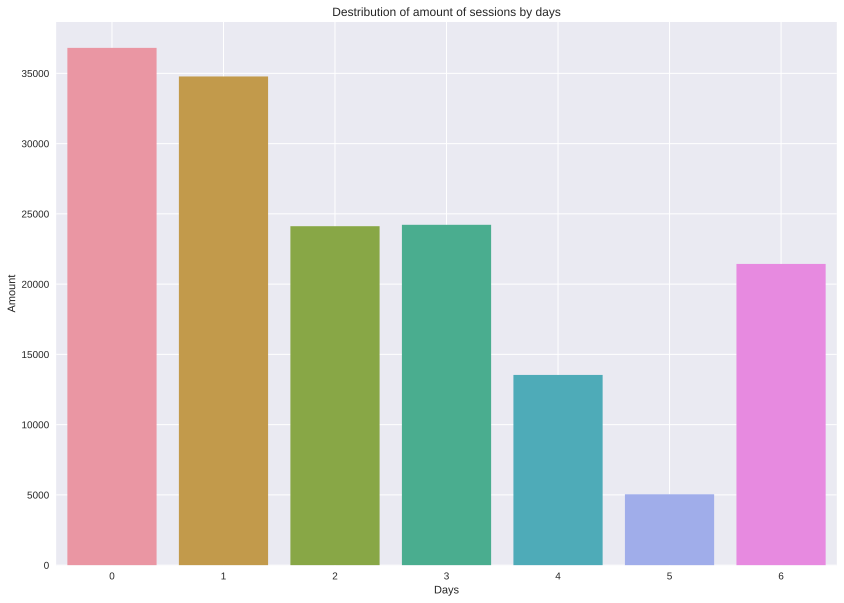

In [422]:
plt.figure(figsize=(14, 10))
sns.countplot(x=train_test_new['day_of_week'].values, data=train_test_new)

plt.xlabel('Days')
plt.ylabel('Amount')
plt.title('Destribution of amount of sessions by days')
plt.grid(True)
plt.show()

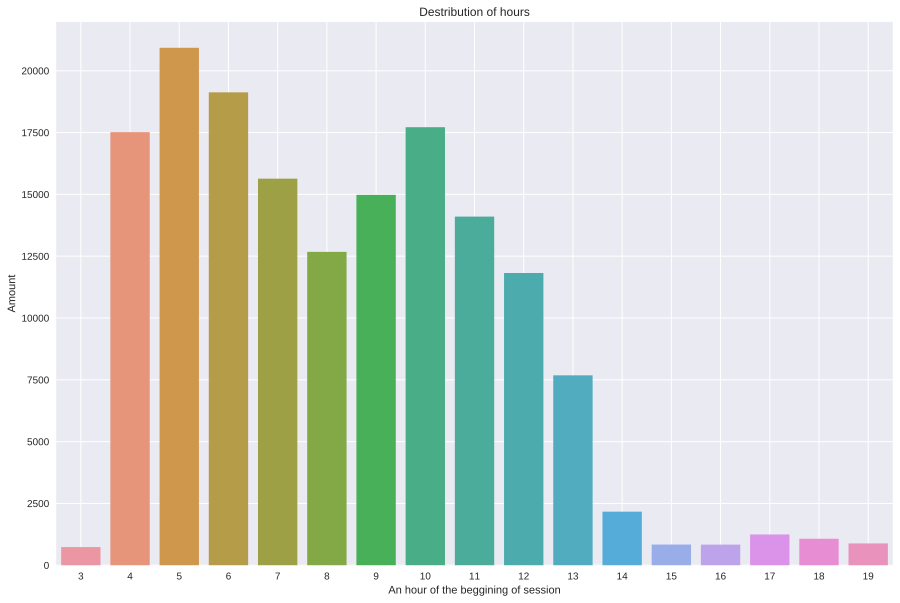

In [423]:
plt.figure(figsize=(15, 10))
sns.countplot(x='start_hour', data=train_test_new)

plt.xlabel('An hour of the beggining of session')
plt.ylabel('Amount')
plt.title('Destribution of hours')
plt.grid(True)
plt.show()

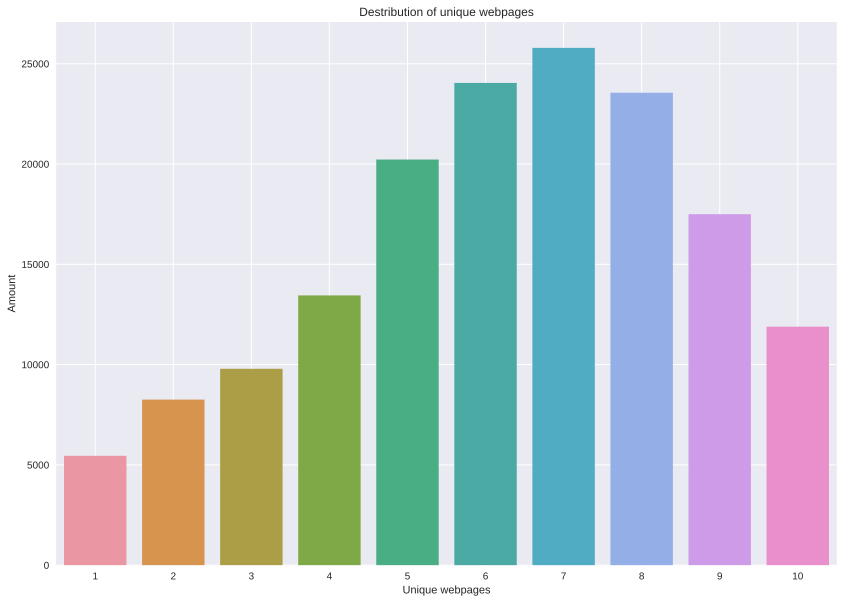

In [424]:
plt.figure(figsize=(14, 10))
sns.countplot(x=train_test_new['unique_sites'].values, data=train_test_new)

plt.xlabel('Unique webpages')
plt.ylabel('Amount')
plt.title('Destribution of unique webpages')
plt.grid(True)
plt.show()

# **Correlation**

* Evaluation of the pairwise dependencies of numerical features.
* Calculation and visualization of the correlation matrix.

In [425]:
corr_matrix = train_test_new.corr().round(4) 
corr_matrix

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,start_hour,day_of_week,unique_sites
time_diff1,1.0000,0.0838,0.0568,0.0624,0.0481,0.0373,0.0280,0.0204,0.0164,0.4223,0.0289,0.0159,0.0212
time_diff2,0.0838,1.0000,0.0720,0.0644,0.0544,0.0325,0.0278,0.0204,0.0154,0.4548,0.0346,0.0146,0.0214
time_diff3,0.0568,0.0720,1.0000,0.1031,0.0764,0.0629,0.0450,0.0297,0.0216,0.4425,0.0180,0.0115,0.0034
time_diff4,0.0624,0.0644,0.1031,1.0000,0.1171,0.0767,0.0627,0.0453,0.0334,0.4256,0.0152,0.0139,-0.0129
time_diff5,0.0481,0.0544,0.0764,0.1171,1.0000,0.1081,0.0730,0.0605,0.0425,0.4170,0.0111,0.0134,-0.0227
time_diff6,0.0373,0.0325,0.0629,0.0767,0.1081,1.0000,0.1073,0.0745,0.0670,0.3949,0.0071,0.0081,-0.0292
time_diff7,0.0280,0.0278,0.0450,0.0627,0.0730,0.1073,1.0000,0.0995,0.0827,0.3705,0.0035,0.0024,-0.0362
time_diff8,0.0204,0.0204,0.0297,0.0453,0.0605,0.0745,0.0995,1.0000,0.0993,0.3517,0.0001,0.0065,-0.0327
time_diff9,0.0164,0.0154,0.0216,0.0334,0.0425,0.0670,0.0827,0.0993,1.0000,0.3309,-0.0030,0.0100,-0.0415
session_timespan,0.4223,0.4548,0.4425,0.4256,0.4170,0.3949,0.3705,0.3517,0.3309,1.0000,0.0359,0.0275,-0.0270


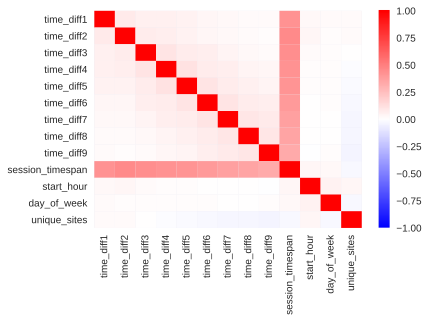

In [426]:
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='bwr')
plt.show()

**Conclusion**:  
* It is important to understand that if the variables are strongly related to each other, then this can affect the training of the model in a bad way. The model will not adequately calculate the weights and parameters of the model. Therefore, it is better to remove such signs.

* At first glance, it is possible to distinguish a pair of red squares, the greatest dependence is observed between these features.  
1) Features **"webpage1-10"**

* The correlation between these features is strong, which may indicate a situation of multicollinearity.
* It can be concluded that they give almost the same information, so multicollinearity really takes place.

## **Correlation coefficients**

In [427]:
import numpy.ma as ma

print(ma.corrcoef(ma.masked_invalid(train_test_new['time_diff2']), ma.masked_invalid(train_test_new['session_timespan'])))

[[1.0 0.45478881544115884]
 [0.45478881544115884 1.0]]


**Conclusion**

* These correlations is about 0.45, not a strong positive correlation.
* There are NOT a strong correlations between features, no multicollinearity in the data, so I shouldn't delete  features.

# **More preprocessing**

In [428]:
ttn_numeric = train_test_new.loc[:, :'session_timespan']
ttn_dummy = train_test_new.loc[:, 'start_hour':]

In [429]:
scaler = StandardScaler()

In [430]:
tt_dummy = pd.get_dummies(ttn_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites', 'day_time']],\
                                  columns=ttn_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites', 'day_time']].columns,\
                                  drop_first=True)
tt_dummy.head()

,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,unique_sites_2,unique_sites_3,unique_sites_4,unique_sites_5,unique_sites_6,unique_sites_7,unique_sites_8,unique_sites_9,unique_sites_10,day_time_evening,day_time_morning,day_time_night
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [431]:
numerical = ttn_numeric.columns
numerical

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan'],
      dtype='object')

In [432]:
numerical = ttn_numeric.columns
ttn_numeric[numerical] = scaler.fit_transform(ttn_numeric[numerical])

**Log transform**

In [433]:
for feat in numerical:
  ttn_numeric[feat] = np.log1p(ttn_numeric[feat])

In [434]:
ttn_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159953 entries, 0 to 159968
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_diff1        159953 non-null  float64
 1   time_diff2        159953 non-null  float64
 2   time_diff3        159953 non-null  float64
 3   time_diff4        159953 non-null  float64
 4   time_diff5        159953 non-null  float64
 5   time_diff6        159953 non-null  float64
 6   time_diff7        159953 non-null  float64
 7   time_diff8        159953 non-null  float64
 8   time_diff9        159953 non-null  float64
 9   session_timespan  159953 non-null  float64
dtypes: float64(10)
memory usage: 18.4 MB


In [435]:
ttn_numeric.shape

(159953, 10)

In [436]:
new_df = pd.concat([ttn_numeric, tt_dummy], axis=1)

In [437]:
new_df.head().T

session_id,0,1,2,3,4
time_diff1,-0.213598,-0.213598,-0.200856,-0.213598,-0.213598
time_diff2,-0.197079,-0.185594,-0.185594,-0.197079,-0.174239
time_diff3,-0.207088,-0.207088,-0.207088,-0.207088,-0.194107
time_diff4,-0.213302,-0.213302,-0.213302,0.165608,-0.213302
time_diff5,-0.212765,-0.212765,-0.212765,0.527212,-0.212765
time_diff6,-0.212924,-0.196244,-0.196244,-0.212924,-0.212924
time_diff7,-0.213765,-0.213765,-0.196204,-0.196204,-0.178946
time_diff8,-0.209911,0.126674,-0.192662,-0.192662,-0.209911
time_diff9,-0.208386,-0.191040,-0.173989,-0.191040,-0.191040
session_timespan,-0.625617,-0.475617,-0.582969,-0.134042,-0.588951


In [438]:
new_df.shape

(159953, 44)

A **sparse matrix** is one that has most of the elements in the form of zeros, and not a dense one, in which most of the elements have non-zero values. In the presence of a large matrix, as a rule, most of the elements are zeros. Therefore, it makes sense to use only non-zero values to perform operations, since zero times something will always give zero.

In [439]:
new_df_sparse = csr_matrix(new_df)
new_df_sparse.shape

(159953, 44)

**Spliting**

In [440]:
train_share = int(.7 * X_train_sparse.shape[0])
new_df_sparse_train, new_df_sparse_valid = new_df_sparse[:train_share, :], new_df_sparse[train_share:, :]

In [441]:
X_train = hstack([X_train, new_df_sparse_train])
X_valid = hstack([X_valid, new_df_sparse_valid])

**Working with test**

In [442]:
test_new = feature_engineering(test)

In [443]:
test_new['day_time'] = test_new.loc[:, 'start_hour'].apply(get_day_time)

test_new['day_time'].value_counts()

morning    43480
night      35834
day        13693
evening      331
Name: day_time, dtype: int64

In [444]:
test_new.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,start_hour,day_of_week,unique_sites,day_time
session_id,,,,,,,,,,,,,,
0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,6,3,1,night
1,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,6,3,4,night
2,8.0,263.0,41.0,374.0,0.0,0.0,0.0,0.0,0.0,686.0,11,0,3,morning
3,27.0,0.0,0.0,1.0,0.0,0.0,16.0,0.0,1.0,45.0,12,6,7,day
4,1.0,2.0,0.0,59.0,1.0,117.0,929.0,0.0,1.0,1110.0,9,6,7,morning


In [445]:
test_new_numeric = test_new.loc[:, :'session_timespan']
test_new_dummy = test_new.loc[:, 'start_hour':]

In [446]:
test_dummy = pd.get_dummies(test_new_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites', 'day_time']],\
                                  columns=test_new_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites', 'day_time']].columns,\
                                  drop_first=True)

In [447]:
numeric = test_new_numeric.columns
test_new_numeric[numerical] = scaler.fit_transform(test_new_numeric[numerical])

In [448]:
new_df_test = pd.concat([test_new_numeric, test_dummy], axis=1)

In [449]:
new_df_test.columns

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan', 'start_hour_4', 'start_hour_5', 'start_hour_6',
       'start_hour_7', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'unique_sites_2',
       'unique_sites_3', 'unique_sites_4', 'unique_sites_5', 'unique_sites_6',
       'unique_sites_7', 'unique_sites_8', 'unique_sites_9', 'unique_sites_10',
       'day_time_evening', 'day_time_morning', 'day_time_night'],
      dtype='object')

In [450]:
new_df_test_sparse = csr_matrix(new_df_test)
new_df_test_sparse.shape

(93338, 44)

In [451]:
X_test = hstack([X_test_sparse, new_df_test_sparse])

In [452]:
X_test.shape

(93338, 541009)

In [453]:
X_train = vstack([X_train, X_valid])

In [454]:
X_train.shape

(159953, 541009)

# **Logistic Regression**

This model shows the best score:

Lets tune some parametrs

In [ ]:
params = {'penalty' : ['l1', 'l2'],
          'tol' : [1e-3, 1e-4],
          'C' : [0.001,0.01,0.1,1,10,100,1000],
          'solver' : ['liblinear']}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
svcm = LogisticRegression( random_state=42)
gd = GridSearchCV(svcm,
                  params,
                  cv=rskf, 
                  scoring='roc_auc',
                  n_jobs=-1)

In [ ]:
gd.fit(X_train, y)

In [ ]:
gd.best_params_

Train model after tuning params:

In [455]:
lgb_clf = LogisticRegression(random_state=42,
                              C=10,
                              max_iter=1000,
                              fit_intercept=True,
                              penalty='l2',
                              solver='liblinear',
                              tol=0.0001,
                              verbose=1)

In [456]:
lgb_clf.fit(X_train, y)

[LibLinear]

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [457]:
preds = lgb_clf.predict(X_test)

ROC AUC: 
    macro: 0.99636 
    weighted: 0.99636


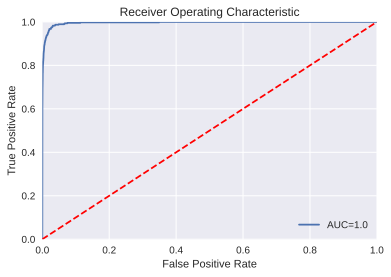

In [458]:
count_roc_auc(lgb_clf, X_valid, y_valid, num_classes, classes_names)

In [459]:
lgb_clf.score(X_valid, y_valid)

0.9963947818113617

In [460]:
pred = lgb_clf.predict_proba(X_test)[:, 1]
save_submission(pred, 'outp.csv') # 0.94672